# Setup

In [1010]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision

import os
import numpy as np
import matplotlib.pyplot as plt

In [1153]:
# define utility functions

def apply_field(img, field):
    # create identity coordinate grid
    grid = torch.stack(torch.meshgrid(torch.arange(28), torch.arange(28)), dim=-1).float()
    grid = grid.unsqueeze(0)  # Add batch dimension
    grid = grid.repeat(img.shape[0], 1, 1, 1)
    grid = (grid / 28) * 2 - 1
    
    # add field to grid
    field = field.permute(0,2,3,1)
    coords_adj = grid + field
    coords_adj = coords_adj.float().permute(0,2,1,3)

    # adjust image
    img_adj = F.grid_sample(img, coords_adj, mode="bilinear", align_corners=True)
    
    return(img_adj)

def loss(img1, img2, field, lmbda):
    """Calculates loss associated with image reconstruction and associated field."""
    
    # approximate field gradient
    diff_x = torch.diff(field[:,:,:,0], axis=1)
    diff_y = torch.diff(field[:,:,:,1], axis=2)
    diff_x = F.pad(diff_x, (0, 0, 1, 0), mode='constant')
    diff_y = F.pad(diff_y, (1, 0, 0, 0), mode='constant')

    # calculate loss
    loss_sim = torch.sum((img1 - img2)**2)
    #loss_sim = cross_correlation(img1, img2, 3)    
    loss_smooth = torch.sum(diff_x**2 + diff_y**2)
    loss_total = loss_sim + lmbda * loss_smooth
    return(loss_total)

def show_images(img, img_adj, img_goal):  
    # convert pytorch to numpy
    img = img.detach().numpy()
    img_adj = img_adj.detach().numpy()
    img_goal = img_goal.detach().numpy()    
    
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(img_adj)
    plt.title('Estimated Image')

    plt.subplot(1, 3, 3)
    plt.imshow(img_goal)
    plt.title('Goal Image')

    plt.show()

In [1154]:
def cross_correlation(img1, img2, n):
    # preprocessing
    img1 = img1 + torch.rand(28,28)*0.0001 # this avoids having zeros in denominator
    img2 = img2 + torch.rand(28,28)*0.0001 # that lead to nan outputs
    delta = int((n-1)/2)
    
    # iterate through pixels
    cross_corr = 0
    for x in range(1,26):
        for y in range(1,26):
            # define kernel
            img_sub1 = img1[(x - delta):(x + delta + 1), (y - delta):(y + delta + 1)].float()
            img_sub2 = img2[(x - delta):(x + delta + 1), (y - delta):(y + delta + 1)].float()
            
            # calculate mean intensities
            # calculate difference from root pixel intensity
            img_sub_norm1 = img_sub1 - torch.mean(img_sub1)
            img_sub_norm2 = img_sub2 - torch.mean(img_sub2)
            
            # calculate numerator/denominator
            num = (torch.sum(img_sub_norm1 * img_sub_norm2))**2
            denom = (torch.sum(img_sub_norm1 * img_sub_norm1)) * (torch.sum(img_sub_norm2 * img_sub_norm2))
            
            cross_corr += (num / denom)
    
    return cross_corr

In [1210]:
# define model architecture

class DeformatioNet(nn.Module):
    def __init__(self, n_1, n_2, n_3):
        super(DeformatioNet, self).__init__()
        
        self.Encoder = nn.Sequential(
                nn.Conv2d(2, n_1,5, stride=1, padding=2),
                nn.BatchNorm2d(n_1),
                nn.Sigmoid(),
                nn.Dropout(0.2),
                nn.MaxPool2d(2),
                nn.Conv2d(n_1, n_2, 3, stride=1, padding=1),
                nn.BatchNorm2d(n_2),
                nn.Sigmoid(),
                nn.Dropout(0.2),
                nn.MaxPool2d(2),
                #nn.Conv2d(n_2, n_3, 3, stride=1, padding=1),
                #nn.BatchNorm2d(n_3),
                #nn.Softplus(),
                #nn.Dropout(0.2),
            )

        self.Decoder = nn.Sequential(
                #nn.ConvTranspose2d(n_3, n_2, 3, stride=1, padding=1),
                #nn.BatchNorm2d(n_2),
                #nn.Softplus(),
                #nn.Dropout(0.2),
                nn.ConvTranspose2d(n_2, n_1, 3, stride=1, padding=1),
                nn.BatchNorm2d(n_1),
                nn.Sigmoid(),
                nn.Upsample(scale_factor=2),
                nn.Dropout(0.2),
                nn.ConvTranspose2d(n_1, 2, 5, stride=1, padding=2),
                nn.BatchNorm2d(2),
                nn.Upsample(scale_factor=2),
                nn.Dropout(0.2),
                nn.Tanh()
            )
    
    def forward(self, x, y):
        # stack images
        z = torch.cat((x,y),
                      dim=1)
        
        # encode images into latent space
        enc = self.Encoder(z)
        
        # decode latent space into deformation field
        field = self.Decoder(enc)

        # (will use to adjust image in post)
        return(field)

# Model Training

In [1211]:
# set hyperparameters
epochs = 5
batch_size = 28
val_iter = 3
lmbda = 0.001
log_lr = -3

lmbdas = [0.1, 0.01, 0.001, 0.001]
log_lrs = [-1, -2, -3, -4]
n_1s = [8, 16, 32]
n_2s = [32, 64, 128]

In [1212]:
transform = torchvision.transforms.ToTensor()

# load training data
train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train.data = train.data[train.targets == 7]
train.targets = train.targets[train.targets == 7]

# split into training/validation sets
train, val = random_split(train, [int(0.8 * len(train)), len(train) - int(0.8 * len(train))])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
train_loader2 = DataLoader(train, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val, batch_size=batch_size, shuffle=True)

# load test data
test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test.data = test.data[test.targets == 7]
test.targets = test.targets[test.targets == 7]
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test, batch_size=batch_size, shuffle=True)

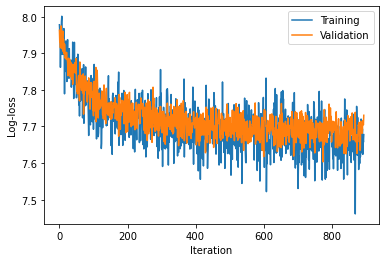

In [1213]:
# training loop

def train_model(model, losses,
                train_loader, train_loader2,
                val_loader, val_loader2,
                val_iter, lmbda, log_lr):
    base_batch = len(losses)
    
    # set optimizer
    optimizer = optim.Adam(model.parameters(), lr=10**log_lr, weight_decay=0)
    
    # run training loop
    
    for batch_id, (img, _) in enumerate(train_loader):
        print(f"Batch {batch_id+1} of {len(train_loader)}", end="\r")
        _, (img_goal, _) = next(enumerate(train_loader2))
        
        # training step
        model.train()
        optimizer.zero_grad()
        
        field = model(img, img_goal)
        
        img_adj = apply_field(img, field)
        
        loss_train = loss(img_adj, img_goal, field, lmbda)
        loss_train.backward()
        optimizer.step()
        
        # validation step
        loss_val = 0
        with torch.no_grad():
            for i in range(val_iter):
                _, (img_val, _) = next(enumerate(val_loader))
                _, (img_val_goal, _) = next(enumerate(val_loader2))
                
                field_val = model(img_val, img_val_goal)
                img_val_adj = apply_field(img_val, field)
                loss_val += loss(img_val_adj, img_val_goal, field_val, lmbda)
            loss_val = loss_val/val_iter

        losses.append([base_batch + batch_id, 
                       torch.log(loss_train).item(), torch.log(loss_val).item()])    
        
    return model, losses

i = 0
for lmbda in lmbdas:
    for log_lr in log_lrs:
        for n_1 in n_1s:
            for n_2 in n_2s:
                i += 1
                
                # load hyperparameters
                # skip if already tested
                if os.path.exists("hyperparameters.pth"):
                    params_load = torch.load("hyperparameters.pth")
                    losses_load = torch.load("losses.pth")
                else:
                    params_load = torch.empty(0,4)
                    losses_load = torch.empty(179*epochs,3,0)

                row_match = (params_load[:, 0] == lmbda) & (params_load[:, 1] == log_lr) & (params_load[:, 2] == n_1) & (params_load[:, 3] == n_2)
                if torch.any(row_match):
                    continue

                # run training loop
                model = DeformatioNet(n_1, n_2)
                
                print(f"Combination {i} of {len(lmbdas)*len(log_lrs)*len(n_1s)*len(n_2s)}")
                print(f"Current parameters: lmbda={lmbda}; log_lr={log_lr}; n_1={n_1}; n_2={n_2}")

                losses = []
                for epoch in range(epochs):
                    print(f"Epoch {epoch+1} of {epochs}     ")
                    model, losses = train_model(model, losses,
                                                train_loader, train_loader2, 
                                                val_loader, val_loader2,
                                                val_iter, lmbda, log_lr)


                # save tested hyperparameters
                losses_save = torch.Tensor(losses).unsqueeze(2)
                params_save = torch.Tensor([lmbda, log_lr, n_1, n_2]).unsqueeze(0)

                losses_out = torch.cat((losses_load, losses_save), dim=2)
                params_out = torch.cat((params_load, params_save), dim=0)

                torch.save(losses_out, "losses.pth")
                torch.save(params_out, "hyperparameters.pth")
                print("Test saved!                    \n")

# plot loss
losses_out = losses_save
plt.plot(losses_out[:,0], losses_out[:,1], label='Training')
plt.plot(losses_out[:,0], losses_out[:,2], label='Validation')

plt.xlabel('Iteration')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

Best model: lmbda=0.10000000149011612, log_lr=-1, n_1=32, n_2=128
Combination 8 of 108
Epoch 1 of 50     
Epoch 2 of 50     
Epoch 3 of 50     
Epoch 4 of 50     
Epoch 5 of 50     
Epoch 6 of 50     
Epoch 7 of 50     
Epoch 8 of 50     
Epoch 9 of 50     
Epoch 10 of 50     
Epoch 11 of 50     
Epoch 12 of 50     
Epoch 13 of 50     
Epoch 14 of 50     
Epoch 15 of 50     
Epoch 16 of 50     
Epoch 17 of 50     
Epoch 18 of 50     
Epoch 19 of 50     
Epoch 20 of 50     
Epoch 21 of 50     
Epoch 22 of 50     
Epoch 23 of 50     
Epoch 24 of 50     
Epoch 25 of 50     
Epoch 26 of 50     
Epoch 27 of 50     
Epoch 28 of 50     
Epoch 29 of 50     
Epoch 30 of 50     
Epoch 31 of 50     
Epoch 32 of 50     
Epoch 33 of 50     
Epoch 34 of 50     
Epoch 35 of 50     
Epoch 36 of 50     
Epoch 37 of 50     
Epoch 38 of 50     
Epoch 39 of 50     
Epoch 40 of 50     
Epoch 41 of 50     
Epoch 42 of 50     
Epoch 43 of 50     
Epoch 44 of 50     
Epoch 45 of 50     
Epoch 46 of 50     
Ep

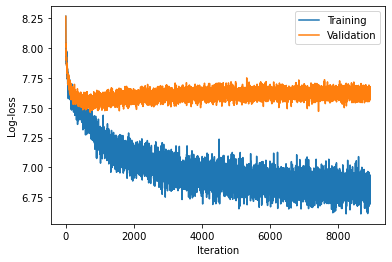

In [1224]:
# load in best hyperparameters
params = torch.load("hyperparameters.pth")
losses = torch.load("losses.pth")

mins, _ = torch.min(losses[:, 2, :], dim=0)
min_all, ind = torch.min(mins, dim=0)

lmbda_best, log_lr_best, n_1_best, n_2_best = params[ind,:]
log_lr_best = int(log_lr_best)
n_1_best = int(n_1_best)
n_2_best = int(n_2_best)

print(f"Best model: lmbda={lmbda_best}, log_lr={log_lr_best}, n_1={n_1_best}, n_2={n_2_best}")
print(f"Combination {ind} of {len(params)}")

# train tuned model
n_1_best = 16
n_2_best = 16
n_3_best = 64
lmbda_best = 1
log_lr_best = -3
model = DeformatioNet(n_1_best, n_2_best, n_3_best)

test_epochs = 50
losses = []
for epoch in range(test_epochs):
    print(f"Epoch {epoch+1} of {test_epochs}     ")
    model, losses = train_model(model, losses,
                                train_loader, train_loader2, 
                                val_loader, val_loader2,
                                val_iter, lmbda_best, log_lr_best)
    
losses_out = torch.Tensor(losses)
plt.plot(losses_out[:,0], losses_out[:,1], label='Training')
plt.plot(losses_out[:,0], losses_out[:,2], label='Validation')

plt.xlabel('Iteration')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

In [1225]:
losses_out.shape

torch.Size([8950, 3])

# Results

In [1229]:
# set up demo images
img, _ = next(iter(test_loader))
img_goal, _ = next(iter(test_loader2))

# generate deformation field
#field = torch.Tensor(np.random.uniform(-0.1, 0.1, (1, 2, 28, 28)))
field = model(img, img_goal)

img_adj = apply_field(img, field)

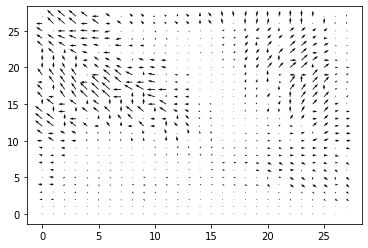

In [1230]:
# display original/transformed images

field_out = field[0,:,:,:]
field_out = field_out.detach().numpy()

x, y = torch.meshgrid(torch.arange(28), torch.arange(28))
plt.quiver(x, y, field_out[0], field_out[1], scale=30)
plt.show()

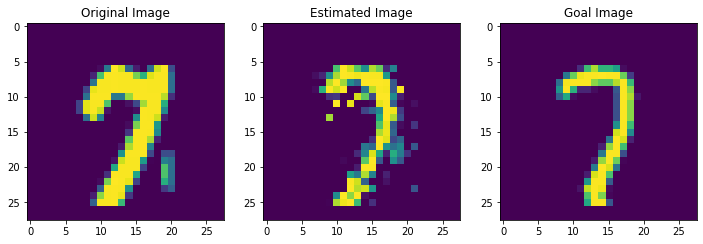

In [1231]:
show_images(img[0, 0, :, :], img_adj[0, 0, :, :], img_goal[0, 0, :, :])

In [646]:
img1 = torch.Tensor(img_goal)
img2 = torch.Tensor(img_adj)
field2 = torch.Tensor(field)

print(img1.shape)
print(img2.shape)
print(field2.shape)

loss(img1, img2, field2, lmbda)

torch.Size([28, 1, 28, 28])
torch.Size([28, 1, 28, 28])
torch.Size([28, 2, 28, 28])


tensor(1954.6737, grad_fn=<AddBackward0>)